## Mounting the Project Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Change current directory to the Project Folder and load the files

In [ ]:
%cd "drive/My Drive/Signature_Verification_Using_SVM_ED"

/content/drive/My Drive/Signature_Verification_Using_SVM_ED


# Signature Identification using SVM

> Installing the necessary libraries



In [ ]:
!pip install imagehash
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17
from __future__ import division
import numpy as np
import cv2
from matplotlib import pyplot as plt
import pandas as pd
import math
from sklearn import preprocessing
from sklearn import svm
from sklearn.metrics import average_precision_score
from pylab import *
import numpy as np
from os import listdir
from sklearn.svm import LinearSVC
import cv2
from PIL import Image
from sklearn import svm
import imagehash
from scipy.cluster.vq import *
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import linear_model
from sklearn.model_selection import cross_validate
from skimage.color import rgb2lab, lab2rgb


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 812 kB 7.3 MB/s 
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295206 sha256=619626051e60dac116e1934a9c6f37a7c0e92864ea1fc83281323ab987b4250d
  Stored in directory: /root/.cache/pip/wheels/4c/d5/59/5e3e297533ddb09407769762985d134135064c6831e29a914e
Successfully built imagehash
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.0 MB 1.3 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requ

## Previewing the Original Image from the dataset

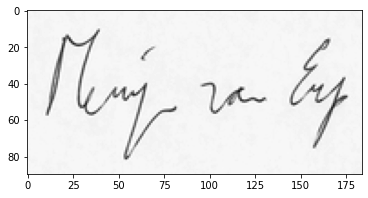

In [ ]:
img = cv2.imread('data/valid/001001_001.png',0)
plt.imshow(img,'gray')
plt.show()

This is the original signature(even though it is not my actual signature), we shall assume that this is the signature we are going to use is my original signature or the signature we need to verify.

## Image Binarization by Applying Gaussian Blurring and Otsu Thresholding

Optimal Threshold value: 223.0


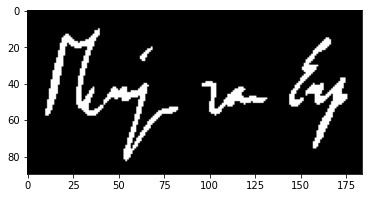

In [ ]:
blur = cv2.GaussianBlur(img,(5,5),0)
#Optimal Threshold value is determined automatically
ret3,th3 = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
image=np.invert(th3)
print('Optimal Threshold value:', ret3)
plt.imshow(image,'gray')
plt.show()

## Cropping out the area of interest in the image
> Indented block



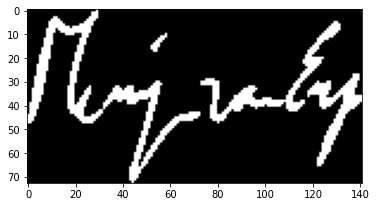

In [ ]:
def crop_image(img,tol=0):
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

cimg=crop_image(image,tol=0)
plt.imshow(cimg,'gray')
plt.show()

The parameters img and tol stand for the image data and tolerance of the image. Cropping out the image helps us extract essential details and discard the uneccessary pixels. 

## Applying Thinning Technique on the Image

> Indented block



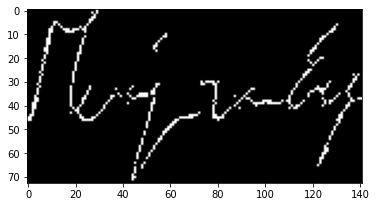

In [ ]:
def thinning(img):
    size = np.size(img)
    skel = np.zeros(img.shape,np.uint8)

    ret,img = cv2.threshold(img,127,255,0)
    element = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
    done = False

    while( not done):
        eroded = cv2.erode(img,element)
        temp = cv2.dilate(eroded,element)
        temp = cv2.subtract(img,temp)
        skel = cv2.bitwise_or(skel,temp)
        img = eroded.copy()

        zeros = size - cv2.countNonZero(img)
        if zeros==size:
            done = True
            
    return skel

timg=thinning(cimg)
plt.imshow(timg,'gray')
plt.show()




## Preprocessing the masked image

In order to generate our dataset that we shall use to train our model so that it can recognise my original signature when a valid signature is presented to it else regard it as invalid. 

In [ ]:
def preprocess_image(path, display=False):
    raw_image = cv2.imread(path)
    bw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2GRAY)
    bw_image = 255 - bw_image

    if display:
        cv2.imshow("RGB to Gray", bw_image)
        cv2.waitKey()

    _, threshold_image = cv2.threshold(bw_image, 30, 255, 0)

    if display:
        cv2.imshow("Threshold", threshold_image)
        cv2.waitKey()

    return threshold_image

## Acquiring the Contour Features from the preprocessed image

In [ ]:
def get_contour_features(im, display=False):
    rect = cv2.minAreaRect(cv2.findNonZero(im))
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    w = np.linalg.norm(box[0] - box[1])
    h = np.linalg.norm(box[1] - box[2])

    aspect_ratio = max(w, h) / min(w, h)
    bounding_rect_area = w * h

    if display:
        image1 = cv2.drawContours(im.copy(), [box], 0, (120, 120, 120), 2)
        cv2.imshow("a", cv2.resize(image1, (0, 0), fx=2.5, fy=2.5))
        cv2.waitKey()

    hull = cv2.convexHull(cv2.findNonZero(im))
    
    
    if display:
        convex_hull_image = cv2.drawContours(im.copy(), [hull], 0, (120, 120, 120), 2)
        cv2.imshow("a", cv2.resize(convex_hull_image, (0, 0), fx=2.5, fy=2.5))
        cv2.waitKey()

    im2, contours, hierarchy = cv2.findContours(im.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if display:
        contour_image = cv2.drawContours(im.copy(), contours, -1, (120, 120, 120), 3)
        cv2.imshow("a", cv2.resize(contour_image, (0, 0), fx=2.5, fy=2.5))
        cv2.waitKey()

    contour_area = 0
    for cnt in contours:
        contour_area += cv2.contourArea(cnt)
    hull_area = cv2.contourArea(hull)

    return aspect_ratio, bounding_rect_area, hull_area, contour_area




### Applying Scale-invariant Feature Transform (SIFT) operation on Images

In [ ]:
def sift(im, path, display=False):
    raw_image = cv2.imread(path)
    sift=cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(im, None)

    if display:
        cv2.drawKeypoints(im, kp, raw_image)
        cv2.imshow('sift_keypoints.jpg', cv2.resize(raw_image, (0, 0), fx=3, fy=3))
        cv2.waitKey()

    return (path, des)
prev_log_data = listdir('.logs_1512321/plugins/profile')
for t in prev_log_data: 
    if ' ' in t: _, __ = t.split('.')



### Training our SVM Model

In [ ]:
valid_image_filenames_temp = listdir("data/valid")
invalid_image_filenames_temp = listdir("data/invalid")

valid_image_paths = "data/valid"
invalid_image_paths = "data/invalid"


valid_image_features = [[] for x in range(25)]
invalid_image_features = [[] for x in range(25)]


valid_image_filenames = []
invalid_image_filenames = []
for t in invalid_image_filenames_temp:
    if '.ipynb_checkpoints' not in t:
        invalid_image_filenames.append(t)
    
for g in valid_image_filenames_temp:
    if '.ipynb_checkpoints' not in g:
        valid_image_filenames.append(g)
    
for name in valid_image_filenames:
    signature_id = (int(name.split('_')[0][-3:]))
    #signature_id = int(name.split('_')[0][-3:])
    valid_image_features[signature_id - 1].append({"name": name})

for name in invalid_image_filenames:
    signature_id = (int(name.split('_')[0][-3:]))
    invalid_image_features[signature_id - 1].append({"name": name})


cor = 0
wrong = 0

im_contour_features = []
im_features = []
#print('Aspect Ratio\t\tBounding Rectangular Area\tConvex-Hull Area\tCOntours Area')
for i in range(25):
    des_list = []
    for im in valid_image_features[i]:
        image_path = valid_image_paths + "/" + im['name']
        preprocessed_image = preprocess_image(image_path)
        hash = imagehash.phash(Image.open(image_path))

        aspect_ratio, bounding_rect_area, convex_hull_area, contours_area = \
            get_contour_features(preprocessed_image.copy(), display=False)
        #print(aspect_ratio,'\t', bounding_rect_area,'\t\t', convex_hull_area,'\t\t', contours_area)

        hash = int(str(hash), 16)
        im['hash'] = hash
        im['aspect_ratio'] = aspect_ratio
        im['hull_area/bounding_area'] = convex_hull_area / bounding_rect_area
        im['contour_area/bounding_area'] = contours_area / bounding_rect_area

        im_contour_features.append([hash, aspect_ratio, convex_hull_area / bounding_rect_area, contours_area / bounding_rect_area])

        des_list.append(sift(preprocessed_image, image_path))


    for im in invalid_image_features[i]:
        image_path = invalid_image_paths + "/" + im['name']
        preprocessed_image = preprocess_image(image_path)
        hash = imagehash.phash(Image.open(image_path))

        aspect_ratio, bounding_rect_area, convex_hull_area, contours_area = \
            get_contour_features(preprocessed_image.copy(), display=False)

        hash = int(str(hash), 16)
        im['hash'] = hash
        im['aspect_ratio'] = aspect_ratio
        im['hull_area/bounding_area'] = convex_hull_area / bounding_rect_area
        im['contour_area/bounding_area'] = contours_area / bounding_rect_area

        im_contour_features.append([hash, aspect_ratio, convex_hull_area / bounding_rect_area, contours_area / bounding_rect_area])

        des_list.append(sift(preprocessed_image, image_path))
    #print(des_list)

    descriptors = des_list[0][1]
    for image_path, descriptor in des_list[1:]:
        descriptors = np.vstack((descriptors, descriptor))
    k = 120
    voc, variance = kmeans(descriptors, k, 1)

    # Calculate the histogram of features
   
    im_features = np.zeros((len(valid_image_features[i]) + len(invalid_image_features[i]), k+4), "float32")
    for i in range(len(valid_image_features[i]) + len(invalid_image_features[i])):
        words, distance = vq(des_list[i][1], voc)
        for w in words:
            im_features[i][w] += 1

        for j in range(4):
            im_features[i][k+j] = im_contour_features[i][j]

    stdSlr = StandardScaler().fit(im_features)
    im_features = stdSlr.transform(im_features)

    train_valid_features, test_valid_features = im_features[0:3], im_features[3:5]

    train_invalid_features, test_invalid_features = im_features[5:8], im_features[8:10]

 

    clf = LinearSVC()

    clf.fit(np.concatenate((train_invalid_features,train_valid_features)), np.array([1 for x in range(len(train_invalid_features))] + [2 for x in range(len(train_valid_features))]))

    valid_res = clf.predict(test_valid_features)


    for res in valid_res:
        if int(res) == 2:
            cor += 1
        else:
            wrong += 1

   
    invalid_res = clf.predict(test_invalid_features)


    for res in invalid_res:
        if int(res) == 1:
            cor += 1
        else:
            wrong += 1 

print("Accuracy: ", float(cor)/(cor+wrong))
y_score = clf.decision_function(test_valid_features)
#print(y_score)

Accuracy:  0.91


## Testing the accuracy

Let's define our testing function which would extract the features required from the test image

In [ ]:
def test(image_path):
    valid_image_filenames_temp = listdir("data/valid")
    invalid_image_filenames_temp = listdir("data/invalid")

    valid_image_paths = "data/valid"
    invalid_image_paths = "data/invalid"

    valid_image_features = [[] for x in range(25)]
    invalid_image_features = [[] for x in range(25)]
    
    valid_image_filenames = []
    invalid_image_filenames = []
    for t in invalid_image_filenames_temp:
        if '.ipynb_checkpoints' not in t:
            invalid_image_filenames.append(t)
    
    for t in valid_image_filenames_temp:
        if '.ipynb_checkpoints' not in t:
            valid_image_filenames.append(t)
    
    
    for name in valid_image_filenames:
        signature_id = int(name.split('_')[0][-3:])
        valid_image_features[signature_id - 1].append({"name": name})

    for name in invalid_image_filenames:
        signature_id = int(name.split('_')[0][-3:])
        invalid_image_features[signature_id - 1].append({"name": name})
    if '_' in image_path: return _

    cor = 0
    wrong = 0

    im_contour_features = []
    im_features = []

    for i in range(25):
        des_list = []
        for im in valid_image_features[i]:
            preprocessed_image = preprocess_image(image_path)
            hash = imagehash.phash(Image.open(image_path))

            aspect_ratio, bounding_rect_area, convex_hull_area, contours_area = \
                get_contour_features(preprocessed_image.copy(), display=False)

            hash = int(str(hash), 16)
            im['hash'] = hash
            im['aspect_ratio'] = aspect_ratio
            im['hull_area/bounding_area'] = convex_hull_area / bounding_rect_area
            im['contour_area/bounding_area'] = contours_area / bounding_rect_area

            im_contour_features.append([hash, aspect_ratio, convex_hull_area / bounding_rect_area, contours_area / bounding_rect_area])

            des_list.append(sift(preprocessed_image, image_path))


        for im in invalid_image_features[i]:
            preprocessed_image = preprocess_image(image_path)
            hash = imagehash.phash(Image.open(image_path))

            aspect_ratio, bounding_rect_area, convex_hull_area, contours_area = \
                get_contour_features(preprocessed_image.copy(), display=False)

            hash = int(str(hash), 16)
            im['hash'] = hash
            im['aspect_ratio'] = aspect_ratio
            im['hull_area/bounding_area'] = convex_hull_area / bounding_rect_area
            im['contour_area/bounding_area'] = contours_area / bounding_rect_area
            
            im_contour_features.append([hash, aspect_ratio, convex_hull_area / bounding_rect_area, contours_area / bounding_rect_area])

            des_list.append(sift(preprocessed_image, image_path))

        descriptors = des_list[0][1]
        for image_path, descriptor in des_list[1:]:
            descriptors = np.vstack((descriptors, descriptor))
        k = 120
        voc, variance = kmeans(descriptors, k, 1)

        # Calculate the histogram of features
        
        im_features = np.zeros((len(valid_image_features[i]) + len(invalid_image_features[i]), k+4), "float32")
        for i in range(len(valid_image_features[i]) + len(invalid_image_features[i])):
            words, distance = vq(des_list[i][1], voc)
            for w in words:
                im_features[i][w] += 1

            for j in range(4):
                im_features[i][k+j] = im_contour_features[i][j]

        #nbr_occurences = np.sum((im_features > 0) * 1, axis=0)
        #idf = np.array(np.log((1.0 * len(image_paths) + 1) / (1.0 * nbr_occurences + 1)), 'float32')

        # Scaling the words
        stdSlr = StandardScaler().fit(im_features)
        im_features = stdSlr.transform(im_features)

        train_valid_features, test_valid_features = im_features[0:3], im_features[3:5]

        train_invalid_features, test_invalid_features = im_features[5:8], im_features[8:10]

        #clf = linear_model.LogisticRegression(C=1e5)

        clf = LinearSVC()
        #clf = tree.DecisionTreeClassifier()
        #clf = tree.DecisionTreeRegressor()
        #clf = svm.SVC()
        clf.fit(np.concatenate((train_invalid_features,train_valid_features)), np.array([1 for x in range(len(train_invalid_features))] + [2 for x in range(len(train_valid_features))]))

        #print("2" + str(clf.predict(test_valid_features)))
        
        valid_res = clf.predict(test_valid_features)

        for res in valid_res:
            if int(res) == 2:
                return "Signature is Real"
            else:
                return "Signature is Forged"

        

    


## Evaluating the Classification Results

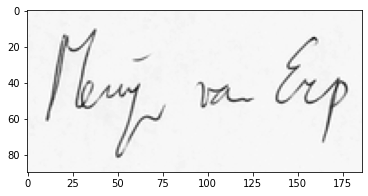

In [ ]:
img = cv2.imread('data/valid/001001_003.png',0)
plt.imshow(img,'gray')
plt.show()

This is a new valid signature not used in the training dataset before. Let us first extract the required features from this picture. Starting with valid features classification and define our test function. 

'Signature is Real'

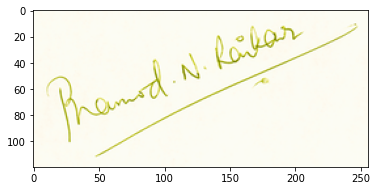

In [ ]:

image_path = "valid.png"
import cv2 
img = cv2.imread(image_path)
plt.imshow(img)
test(image_path)

'Signature is Forged'

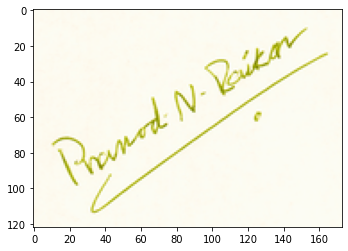

In [ ]:
image_path = "invalid.png"
import cv2 
img = cv2.imread(image_path)
plt.imshow(img)
test(image_path)

'Signature is Forged'

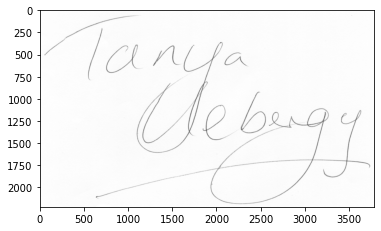

In [ ]:
image_path = "outside_img_1.png"
import cv2 
img = cv2.imread(image_path)
plt.imshow(img)
test(image_path)

'Signature is Forged'

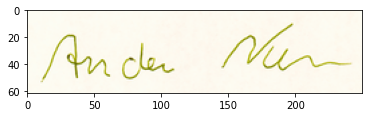

In [ ]:
image_path = "outside_img_2.png"
import cv2 
img = cv2.imread(image_path)
plt.imshow(img)
test(image_path)

'Signature is Forged'

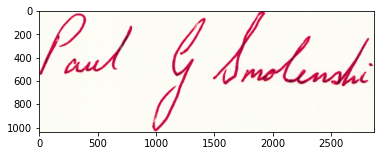

In [ ]:
image_path = "test.png"
import cv2 
img = cv2.imread(image_path)
plt.imshow(img)
test(image_path)

'Signature is Forged'

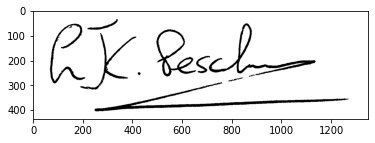

In [ ]:
image_path = "test/test38.png"
import cv2 
img = cv2.imread(image_path)
plt.imshow(img)
test(image_path)

'Signature is Real'

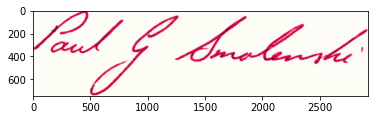

In [ ]:
image_path = "test/test21.png"
import cv2 
img = cv2.imread(image_path)
plt.imshow(img)
test(image_path)

'Signature is Real'

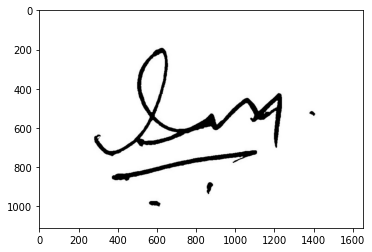

In [ ]:
image_path = "Test_4.png"
import cv2 
img = cv2.imread(image_path)
plt.imshow(img)
test(image_path)

As you can see, the first image was the valid replica of the test image and we have received valid while they next one was a random image so it claimed it to be invalid image and the third one was a invalid attempt so it has been classified as invalid anyway.

**Interface**

In [ ]:
!pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from flask import Flask, render_template, request
from pyngrok import ngrok
import os

In [ ]:
port_no = 5000

In [ ]:
app = Flask(__name__)
ngrok.set_auth_token("2AttBXG1ViEpwD3tkEcj2nhzToP_3tRmf574x74UiaXtx9JAS")
public_url =  ngrok.connect(port_no).public_url

@app.route('/', methods=['GET'])
def home():
    return render_template('index.html')


@app.route('/', methods=['POST'])
def predict_signature():
  imagefile = request.files['imagefile']
  temp=cv2.imwrite('/content/drive/My Drive/Signature_Verification_Using_SVM_ED/test/imagefile.png',imagefile)
  image_path = "test/imagefile.png"
  pred=test(image_path)
  return render_template('index.html', prediction=pred)


print(f"To acces the Gloable link please click {public_url}")

if __name__ == "__main__":
  app.run(port=port_no)

To acces the Gloable link please click http://c570-35-194-90-232.ngrok.io
 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [21/Jun/2022 22:25:37] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [21/Jun/2022 22:25:38] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [21/Jun/2022 22:25:43] "GET /?imagefile=Test_4.png HTTP/1.1" 200 -
